In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Display plots directly in the notebook
%matplotlib inline 
sns.set_theme(style="whitegrid")

# --- PATHS ---
BASE_DIR = "/home/marcos/PRJEB59406/compactados"
INPUT_FILE = f"{BASE_DIR}/abundance_results/unified_abundance_with_groups.tsv"
OUTPUT_DIR = f"{BASE_DIR}/abundance_results/plots"

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Setup complete.")

Setup complete.


In [44]:
import pandas as pd

# Load the unified table
df = pd.read_csv(INPUT_FILE, sep="\t")

# Clean Protein names
if 'Protein' in df.columns:
    df['Protein'] = df['Protein'].str.replace('nanH_without_extra_signatures.', '', regex=False)

# --- REORDER GROUPS (Control First) ---
if 'Group' in df.columns:
    # 1. Get all unique groups and sort them alphabetically
    group_order = sorted(df['Group'].unique())
    
    # 2. Move 'Control' to the front if it exists
    if 'Control' in group_order:
        group_order.remove('Control')
        group_order.insert(0, 'Control') # Insert at index 0
        
    # 3. Apply the new order
    df['Group'] = pd.Categorical(df['Group'], categories=group_order, ordered=True)
    df = df.sort_values('Group')
    
    print(f"Group Order: {group_order}")

# Check columns and data
print(f"Columns: {list(df.columns)}")
display(df.head())

# Check group distribution
if 'Group' in df.columns:
    print("\nSamples per Group (Ordered):")
    print(df['Group'].value_counts(sort=False))
else:
    print("Error: 'Group' column not found!")

Group Order: ['Control', 'Atopic_dermatitis_lesion', 'Atopic_dermatitis_non_lesion']
Columns: ['CDS', 'Protein', 'Abundance', 'Sample', 'Group']


,CDS,Protein,Abundance,Sample,Group
14124,k141_77030_1,nanH_42008_bv,113646.297753,ERR10857000,Control
6020,k141_256718_1,nanH_25003_bv,111749.680715,ERR10856936,Control
6019,k141_256718_1,nanH_64703_bv,111749.680715,ERR10856936,Control
6018,k141_256718_1,nanH_59381_bv,111749.680715,ERR10856936,Control
6017,k141_256718_1,nanH_19364_bv,111749.680715,ERR10856936,Control



Samples per Group (Ordered):
Group
Control                         8031
Atopic_dermatitis_lesion        1337
Atopic_dermatitis_non_lesion    4757
Name: count, dtype: int64


Heatmap relative abundance (Who are present in great quantities?)

/tmp/ipykernel_5321/68390697.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_matrix = matrix.groupby(sample_to_group, axis=1).mean()


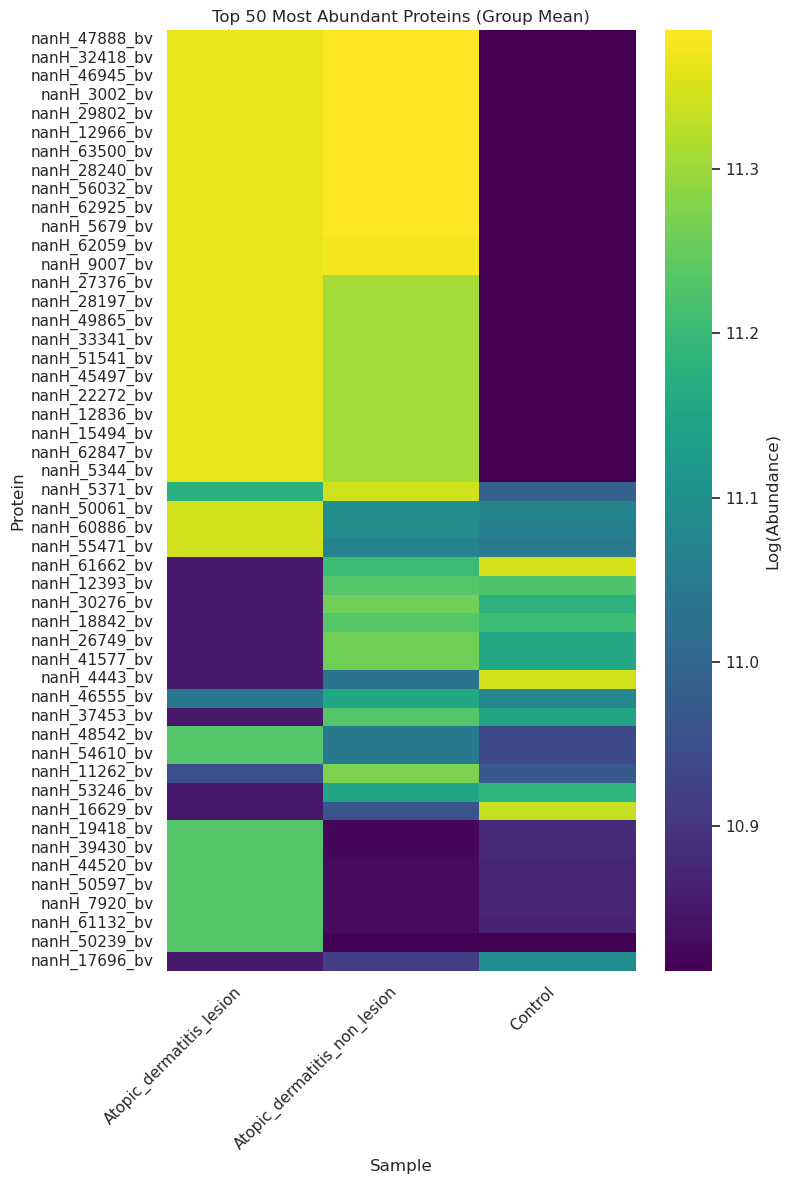

In [45]:
# 1. Prepare Data
id_col = 'Protein' if 'Protein' in df.columns else 'CDS'

# Create Matrix: Rows=Protein, Cols=Sample, Values=Abundance
matrix = df.pivot_table(index=id_col, columns="Sample", values="Abundance", aggfunc="sum").fillna(0)

# Map Samples to Groups and calculate Mean per Group
sample_to_group = dict(zip(df['Sample'], df['Group']))
grouped_matrix = matrix.groupby(sample_to_group, axis=1).mean()

# 2. Select Top 50 (by overall mean)
grouped_matrix['mean_val'] = grouped_matrix.mean(axis=1)
top50 = grouped_matrix.sort_values('mean_val', ascending=False).head(50).drop(columns=['mean_val'])

# 3. Plot Heatmap (Log Scale)
plt.figure(figsize=(8, 12))
sns.heatmap(np.log1p(top50), cmap='viridis', annot=False, cbar_kws={'label': 'Log(Abundance)'})

plt.title("Top 50 Most Abundant Proteins (Group Mean)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Protein")
plt.tight_layout()

plt.savefig(f"{OUTPUT_DIR}/heatmap_top50.png", dpi=300)
plt.show()

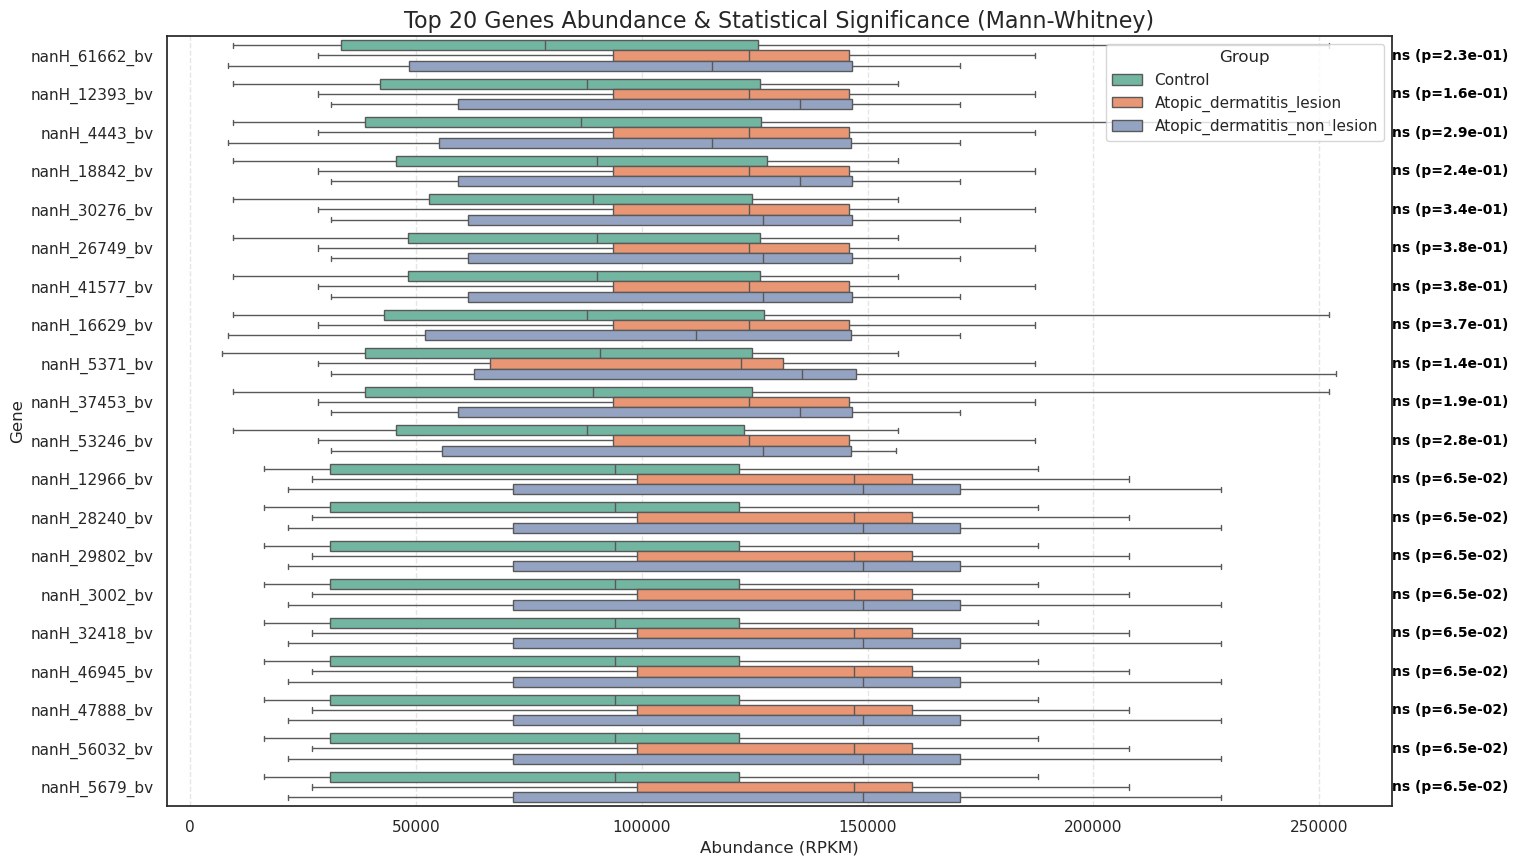

Statistical Results:
             Gene   P-value
12  nanH_28240_bv  0.064962
13  nanH_29802_bv  0.064962
14   nanH_3002_bv  0.064962
15  nanH_32418_bv  0.064962
11  nanH_12966_bv  0.064962
18  nanH_56032_bv  0.064962
17  nanH_47888_bv  0.064962
16  nanH_46945_bv  0.064962
19   nanH_5679_bv  0.064962
8    nanH_5371_bv  0.139288
1   nanH_12393_bv  0.158203
9   nanH_37453_bv  0.190854
0   nanH_61662_bv  0.227509
3   nanH_18842_bv  0.241871
10  nanH_53246_bv  0.276007
2    nanH_4443_bv  0.285619
4   nanH_30276_bv  0.337548
7   nanH_16629_bv  0.372446
5   nanH_26749_bv  0.375236
6   nanH_41577_bv  0.375236


<Figure size 640x480 with 0 Axes>

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, kruskal

# --- 1. LOAD AND PREPARE DATA ---
# (Assuming df is already loaded from previous step)
# df = pd.read_csv(INPUT_FILE, sep="\t") 

# Clean names if needed
if 'Protein' in df.columns:
    df['Protein'] = df['Protein'].str.replace('nanH_without_extra_signatures.', '', regex=False)

# Select Top 20 Genes
top_proteins = df.groupby('Protein')['Abundance'].sum().nlargest(20).index
df_top = df[df['Protein'].isin(top_proteins)]

# --- 2. STATISTICAL CALCULATION ---
# Function to calculate p-value between groups
def calculate_pvalue(df_sub, gene, group_col='Group', value_col='Abundance'):
    groups = df_sub[group_col].unique()
    
    # If exactly 2 groups -> Mann-Whitney U test
    if len(groups) == 2:
        g1 = df_sub[df_sub[group_col] == groups[0]][value_col]
        g2 = df_sub[df_sub[group_col] == groups[1]][value_col]
        try:
            stat, p = mannwhitneyu(g1, g2)
            return p
        except:
            return 1.0
            
    # If > 2 groups -> Kruskal-Wallis test
    elif len(groups) > 2:
        data_groups = [df_sub[df_sub[group_col] == g][value_col] for g in groups]
        try:
            stat, p = kruskal(*data_groups)
            return p
        except:
            return 1.0
    return 1.0

# Store p-values in a dictionary
p_values = {}
for gene in top_proteins:
    df_gene = df_top[df_top['Protein'] == gene]
    p = calculate_pvalue(df_gene, gene)
    p_values[gene] = p

# --- 3. PLOTTING WITH STATS ---
plt.figure(figsize=(14, 10)) # Increased width for text

# Create the plot
ax = sns.boxplot(data=df_top, x='Abundance', y='Protein', hue='Group', 
                 order=top_proteins, palette="Set2", showfliers=False)

# Add p-values text to the right of the boxes
x_max = df_top['Abundance'].max() * 1.05 # Margin for text
for i, gene in enumerate(top_proteins):
    p = p_values.get(gene, 1.0)
    
    # Determine significance stars
    if p < 0.001:   sig = '***'
    elif p < 0.01:  sig = '**'
    elif p < 0.05:  sig = '*'
    else:           sig = 'ns' # not significant
    
    # Text to display
    text = f"{sig} (p={p:.1e})"
    
    # Position text (y=i corresponds to the gene index on y-axis)
    # x is set to the max value of the plot or a specific limit
    # We place it at the far right of the plot area
    plt.text(x=ax.get_xlim()[1], y=i, s=text, 
             va='center', ha='left', fontsize=10, color='black', fontweight='bold')

# Adjust layout to make room for text
plt.subplots_adjust(right=1) 

plt.title("Top 20 Genes Abundance & Statistical Significance (Mann-Whitney)", fontsize=16)
plt.xlabel("Abundance (RPKM)")
plt.ylabel("Gene")
plt.legend(title='Group')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.show()

# Print Table for checking
print("Statistical Results:")
print(pd.DataFrame(list(p_values.items()), columns=['Gene', 'P-value']).sort_values('P-value'))

plt.savefig(f"{OUTPUT_DIR}/plot_box.png", dpi=300)
plt.show()

 Images will be saved to: /home/marcos/PRJEB59406/abundance_results/plots
4 [-0.28792048  0.32857461]
5 [ 0.18372739 -0.98358253]
✅ Saved: /home/marcos/PRJEB59406/abundance_results/plots/Volcano_Atopic_dermatitis_lesion_vs_Control.png


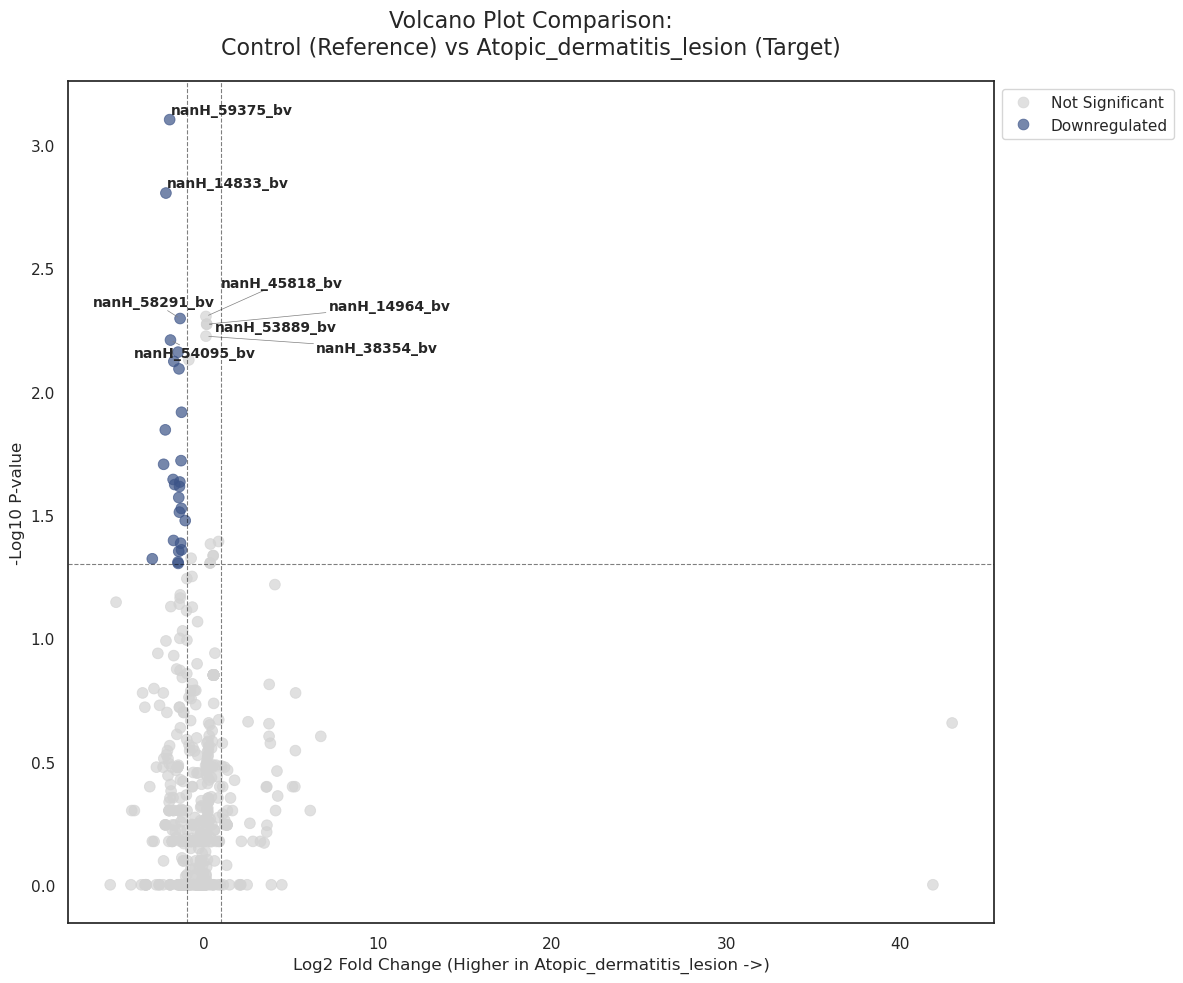

5 [0.78460097 0.98793097]
6 [ 0.17159637 -0.48780712]
✅ Saved: /home/marcos/PRJEB59406/abundance_results/plots/Volcano_Atopic_dermatitis_non_lesion_vs_Control.png


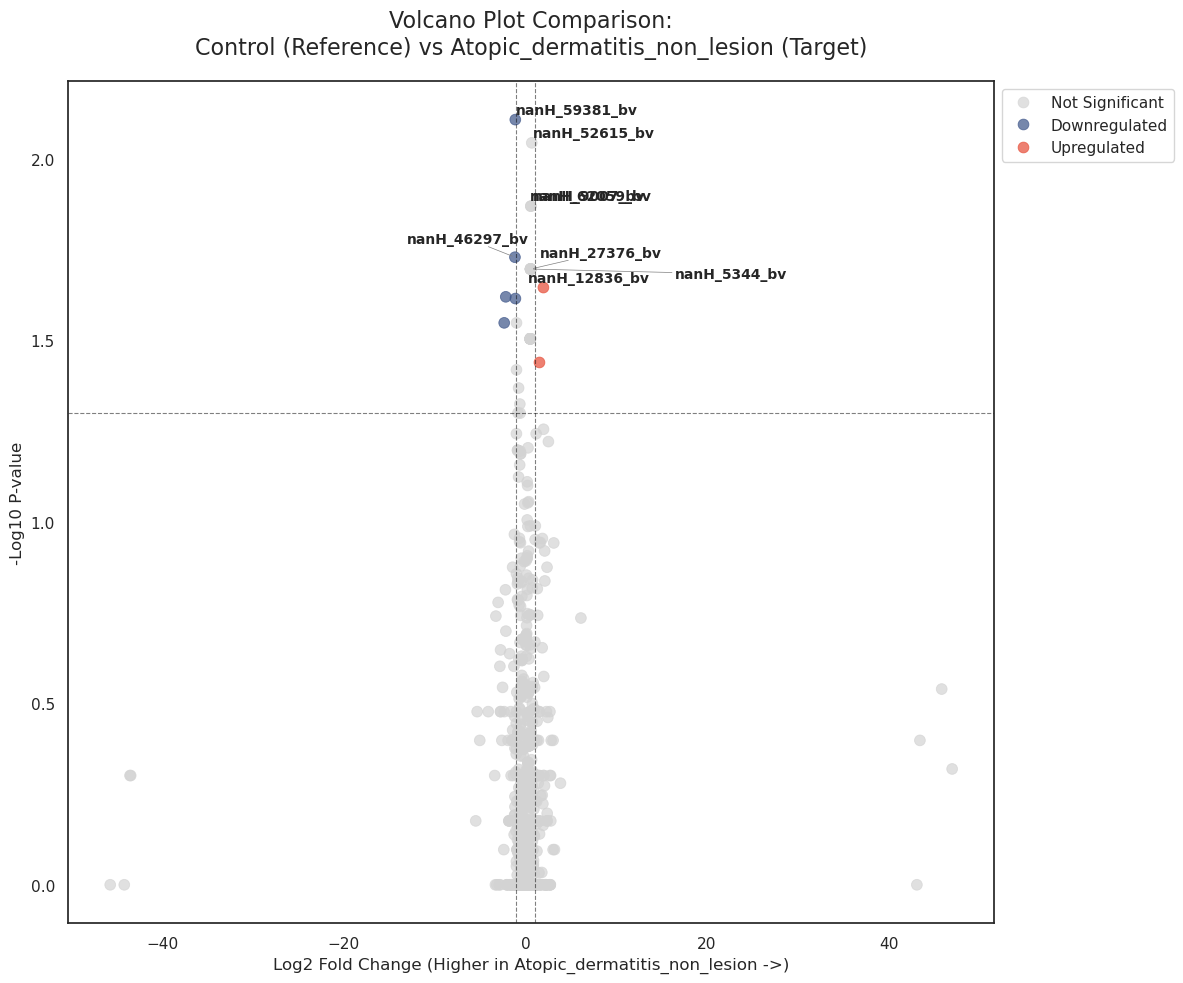

✅ Saved: /home/marcos/PRJEB59406/abundance_results/plots/Volcano_Atopic_dermatitis_non_lesion_vs_Atopic_dermatitis_lesion.png


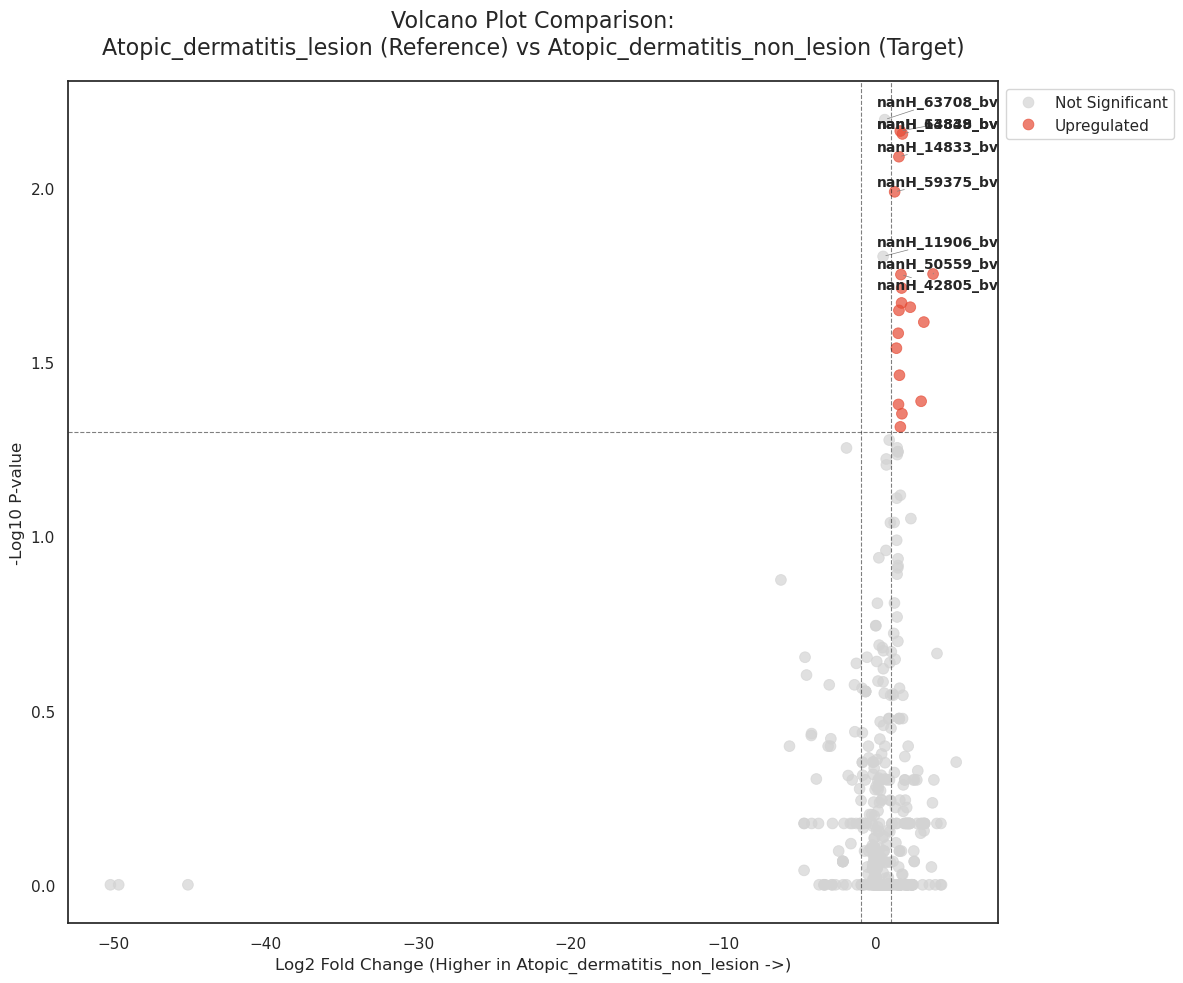

In [49]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
from itertools import combinations

# --- 0. INSTALL ADJUSTTEXT (If missing) ---
try:
    import adjustText
except ImportError:
    print("Installing adjustText library...")
    !pip install adjustText
    import adjustText
from adjustText import adjust_text

# Visual Configuration
sns.set_theme(style="white")
%matplotlib inline

# --- CONFIGURATION: PATHS ---
# Defining the Base Directory (based on your previous paths)
BASE_DIR = "/home/marcos/PRJEB59406"

# Defining the specific Output Directory as requested
OUTPUT_DIR = f"{BASE_DIR}/abundance_results/plots"

# Create the directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f" Images will be saved to: {OUTPUT_DIR}")

# --- 1. DATA PREPARATION ---
# (Uncomment if needed)
# df = pd.read_csv(f"{BASE_DIR}/abundance_results/unified_abundance_with_groups.tsv", sep="\t")

# Clean protein names if needed
if 'Protein' in df.columns:
    df['Protein'] = df['Protein'].str.replace('nanH_without_extra_signatures.', '', regex=False)
    df['Protein'] = df['Protein'].str.replace(r'^.*nanH_', 'nanH_', regex=True)

groups = df['Group'].unique()
pairs = list(combinations(groups, 2))

# --- 2. PLOTTING FUNCTION ---
def plot_volcano_clean(df_main, group1, group2):
    
    results = []
    unique_proteins = df_main['Protein'].unique()
    
    # Calculation Loop
    for protein in unique_proteins:
        df_gene = df_main[df_main['Protein'] == protein]
        vals_g1 = df_gene[df_gene['Group'] == group1]['Abundance'].values
        vals_g2 = df_gene[df_gene['Group'] == group2]['Abundance'].values
        
        if len(vals_g1) == 0 or len(vals_g2) == 0: continue
        
        mean_g1 = np.mean(vals_g1) + 1e-9
        mean_g2 = np.mean(vals_g2) + 1e-9
        log2fc = np.log2(mean_g2 / mean_g1)
        
        try: _, p = mannwhitneyu(vals_g1, vals_g2, alternative='two-sided')
        except: p = 1.0
            
        results.append({'Protein': protein, 'Log2FC': log2fc, 'P_value': p})

    vol_df = pd.DataFrame(results)
    vol_df['-Log10P'] = -np.log10(vol_df['P_value'] + 1e-300)

    # Thresholds
    pval_cut = 0.05
    logfc_cut = 1.0 
    conditions = [
        (vol_df['P_value'] < pval_cut) & (vol_df['Log2FC'] > logfc_cut),
        (vol_df['P_value'] < pval_cut) & (vol_df['Log2FC'] < -logfc_cut)
    ]
    vol_df['Category'] = np.select(conditions, ['Upregulated', 'Downregulated'], default='Not Significant')

    # --- PLOTTING ---
    plt.figure(figsize=(12, 10)) 
    
    palette = {'Upregulated': '#E64B35', 'Downregulated': '#3C5488', 'Not Significant': '#D3D3D3'}
    
    sns.scatterplot(data=vol_df, x='Log2FC', y='-Log10P', hue='Category', 
                    palette=palette, alpha=0.7, s=60, edgecolor=None)
    
    # Lines
    plt.axhline(-np.log10(pval_cut), color='black', ls='--', lw=0.8, alpha=0.5)
    plt.axvline(logfc_cut, color='black', ls='--', lw=0.8, alpha=0.5)
    plt.axvline(-logfc_cut, color='black', ls='--', lw=0.8, alpha=0.5)
    
    # Labels
    top_hits = vol_df.nlargest(8, '-Log10P')
    texts = []
    
    for _, row in top_hits.iterrows():
        texts.append(plt.text(row['Log2FC'], row['-Log10P'], row['Protein'], 
                              fontsize=10, fontweight='bold'))
    
    try: adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    except: pass

    # Titles
    plt.title(f"Volcano Plot Comparison:\n{group1} (Reference) vs {group2} (Target)", 
              fontsize=16, pad=20)
    plt.xlabel(f"Log2 Fold Change (Higher in {group2} ->)", fontsize=12)
    plt.ylabel("-Log10 P-value", fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout() 

    # --- SAVE TO SPECIFIC DIR ---
    safe_g1 = str(group1).replace(" ", "_").replace("/", "-")
    safe_g2 = str(group2).replace(" ", "_").replace("/", "-")
    
    # Constructing the full path using OUTPUT_DIR
    filename = f"{OUTPUT_DIR}/Volcano_{safe_g2}_vs_{safe_g1}.png"
    
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {filename}")
    
    plt.show()

# --- EXECUTION ---
for g1, g2 in pairs:
    plot_volcano_clean(df, g1, g2)

Heatmap Fold Change x control

/tmp/ipykernel_5321/2812197049.py:17: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_matrix = matrix.groupby(sample_to_group, axis=1).mean()


✅ Heatmap saved to: /home/marcos/PRJEB59406/abundance_results/plots/heatmap_Log2FC_vs_Control.png


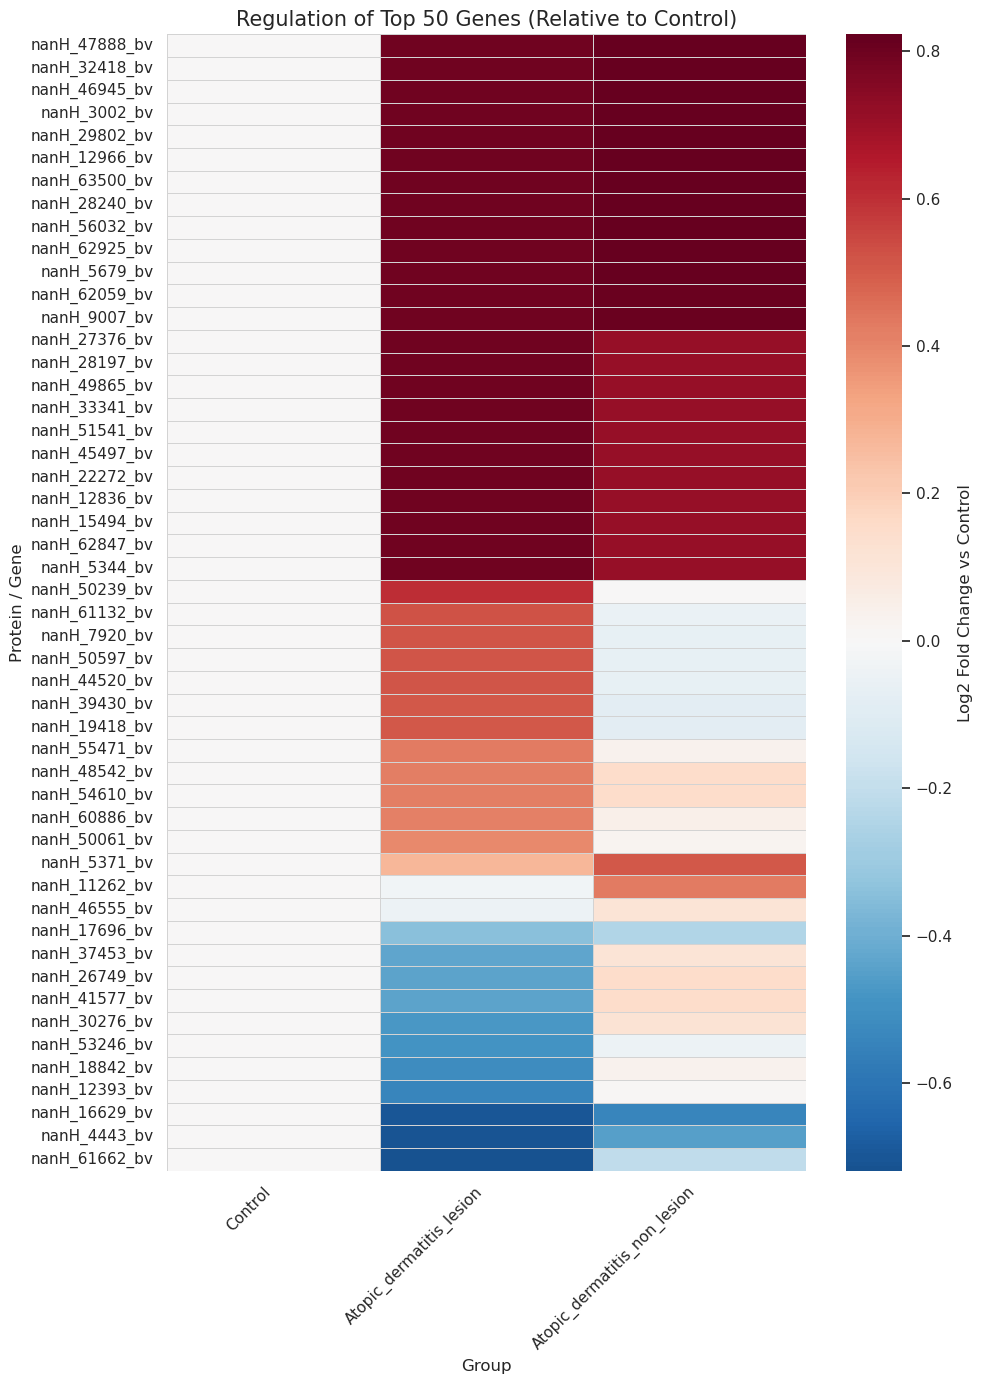

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. DATA PREPARATION ---
# Load data (assuming 'df' and 'OUTPUT_DIR' are already defined)
# df = pd.read_csv(INPUT_FILE, sep="\t")

id_col = 'Protein' if 'Protein' in df.columns else 'CDS'

# Create Matrix: Rows=Protein, Cols=Sample, Values=Abundance
matrix = df.pivot_table(index=id_col, columns="Sample", values="Abundance", aggfunc="sum").fillna(0)

# Map Samples to Groups and calculate Mean per Group
sample_to_group = dict(zip(df['Sample'], df['Group']))
grouped_matrix = matrix.groupby(sample_to_group, axis=1).mean()

# --- 2. SELECTION AND ORDERING ---
# Ensure 'Control' is the first column (Reference)
columns = sorted(list(grouped_matrix.columns))
if 'Control' in columns:
    columns.remove('Control')
    columns.insert(0, 'Control')
grouped_matrix = grouped_matrix[columns]

# Select Top 50 most abundant proteins (based on total mean) to avoid overcrowding
grouped_matrix['mean_total'] = grouped_matrix.mean(axis=1)
top50 = grouped_matrix.sort_values('mean_total', ascending=False).head(50).drop(columns=['mean_total'])

# --- 3. LOG2 FOLD CHANGE CALCULATION ---
# Add a tiny value (epsilon) to avoid division by zero errors
epsilon = 1e-9 
top50 = top50 + epsilon

# Divide all columns by the Control column and calculate Log2
# Formula: Log2( Group_Value / Control_Value )
log2fc_matrix = np.log2(top50.div(top50['Control'], axis=0))

# Optional: Sort rows by the value of the first disease group (for better visualization)
# This helps cluster upregulated genes at the top
if len(columns) > 1:
    sort_group = columns[1] # The group right after Control
    log2fc_matrix = log2fc_matrix.sort_values(by=sort_group, ascending=False)

# --- 4. PLOT DIVERGENT HEATMAP ---
plt.figure(figsize=(10, 14))

# cmap='RdBu_r': Red-Blue Reverse (Red = Upregulated, Blue = Downregulated)
# center=0: Ensures White represents no change (equal to control)
sns.heatmap(log2fc_matrix, cmap='RdBu_r', center=0, annot=False, 
            cbar_kws={'label': 'Log2 Fold Change vs Control'},
            linewidths=0.5, linecolor='lightgray')

plt.title("Regulation of Top 50 Genes (Relative to Control)", fontsize=15)
plt.xlabel("Group", fontsize=12)
plt.ylabel("Protein / Gene", fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

# Save
filename = f"{OUTPUT_DIR}/heatmap_Log2FC_vs_Control.png"
plt.savefig(filename, dpi=300)
print(f"✅ Heatmap saved to: {filename}")

plt.show()

No outliers

--- REMOVING OUTLIERS (Top 10 Genes) ---
Samples removed: 23
✅ Image saved to: /home/marcos/PRJEB59406/abundance_results/plots/barplot_stats_detailed_legend_top10.png


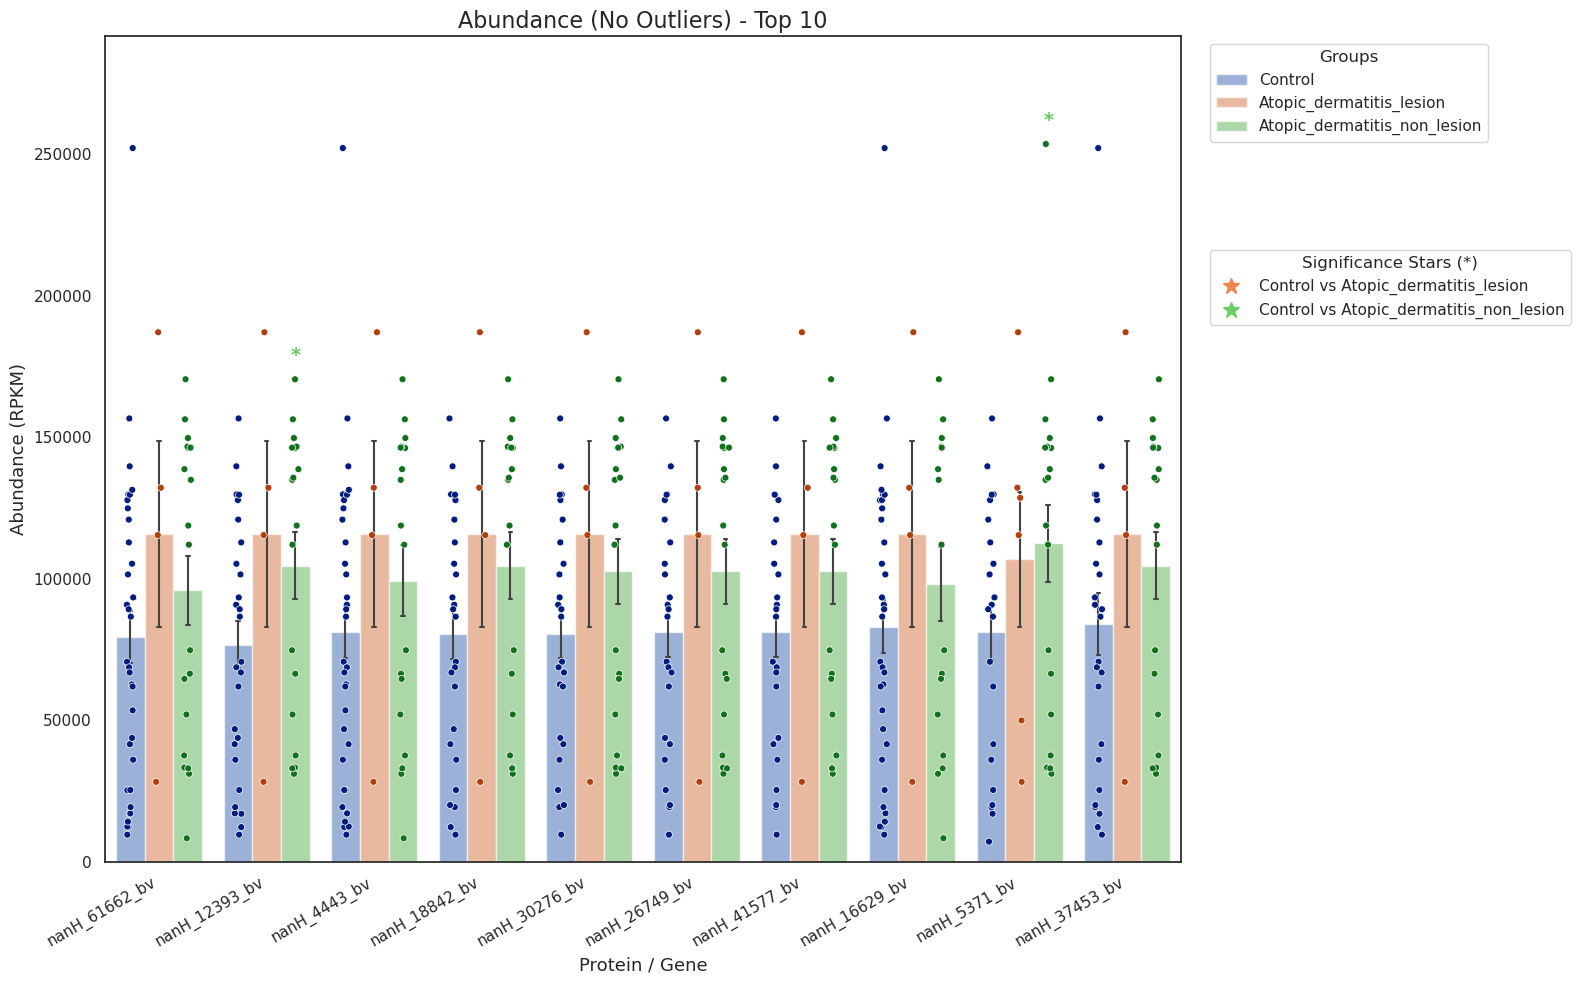

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 
from scipy.stats import mannwhitneyu

# --- 1. SETUP & PREP ---
# (Assumindo df carregado)
# df = pd.read_csv(INPUT_FILE, sep="\t")

if 'Protein' in df.columns:
    df['Protein'] = df['Protein'].str.replace('nanH_without_extra_signatures.', '', regex=False)

control_name = "Control"
existing_groups = sorted(list(df['Group'].unique()))
if control_name in existing_groups:
    existing_groups.remove(control_name)
    existing_groups.insert(0, control_name)

# Top 10
top_n = 10
top_genes = df.groupby('Protein')['Abundance'].sum().nlargest(top_n).index
df_subset = df[df['Protein'].isin(top_genes)]

# --- 2. REMOVE OUTLIERS ---
print(f"--- REMOVING OUTLIERS (Top {top_n} Genes) ---")
indices_to_drop = []
for gene in top_genes:
    for group in existing_groups:
        mask = (df_subset['Protein'] == gene) & (df_subset['Group'] == group)
        data = df_subset[mask]['Abundance']
        if len(data) == 0: continue
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        if not outliers.empty:
            indices_to_drop.extend(outliers.index)

df_clean = df_subset.drop(indices_to_drop)
print(f"Samples removed: {len(indices_to_drop)}")

# --- 3. STATS FUNCTIONS ---
def get_significance(df_in, gene, group_target, group_ref):
    val_ref = df_in[(df_in['Protein'] == gene) & (df_in['Group'] == group_ref)]['Abundance']
    val_target = df_in[(df_in['Protein'] == gene) & (df_in['Group'] == group_target)]['Abundance']
    if len(val_ref) < 2 or len(val_target) < 2: return 1.0
    try:
        _, p = mannwhitneyu(val_ref, val_target, alternative='two-sided')
        return p
    except: return 1.0

def stars(p):
    if p < 0.001: return "***"
    if p < 0.01: return "**"
    if p < 0.05: return "*"
    return "ns"

# --- 4. PLOTTING ---
plt.figure(figsize=(16, 10))

# Create Color Map manually so we can use it in the legend
palette_name = 'muted'
colors = sns.color_palette(palette_name, n_colors=len(existing_groups))
group_color_map = dict(zip(existing_groups, colors))

# A. Bar Plot
ax = sns.barplot(
    data=df_clean, x='Protein', y='Abundance', hue='Group', 
    hue_order=existing_groups, order=top_genes,
    palette=colors, alpha=0.6, errorbar='se', capsize=0.1, err_kws={'linewidth': 1.5}
)

# B. Strip Plot
sns.stripplot(
    data=df_clean, x='Protein', y='Abundance', hue='Group', 
    hue_order=existing_groups, order=top_genes,
    palette='dark', dodge=True, size=5, edgecolor='white', linewidth=0.5, marker='o'
)

# --- 5. ANNOTATIONS ---
n_groups = len(existing_groups)
bar_width = 0.8 / n_groups 
global_y_max = df_clean['Abundance'].max()
y_offset = global_y_max * 0.02 

for i, gene in enumerate(top_genes):
    for j, group in enumerate(existing_groups):
        if group == control_name: continue
        
        p_val = get_significance(df_clean, gene, group, control_name)
        sig_symbol = stars(p_val)
        
        if sig_symbol != "ns":
            x_pos = i + (j - n_groups/2 + 0.5) * bar_width
            group_data = df_clean[(df_clean['Protein'] == gene) & (df_clean['Group'] == group)]['Abundance']
            if group_data.empty: continue
            
            local_peak = group_data.max()
            bar_color = group_color_map[group]
            
            plt.text(x_pos, local_peak + y_offset, sig_symbol, 
                     ha='center', va='bottom', fontsize=14, fontweight='bold', 
                     color=bar_color)

# --- 6. CUSTOM LEGENDS (HERE IS THE CHANGE) ---
plt.title(f"Abundance - Top {top_n}", fontsize=16)
plt.ylabel("Abundance (RPKM)", fontsize=13)
plt.xlabel("Protein / Gene", fontsize=13)
plt.xticks(rotation=30, ha='right')
plt.ylim(0, global_y_max * 1.15) 

# LEGEND 1: GROUPS (Bars)
handles, labels = plt.gca().get_legend_handles_labels()
# Place at top right (outside)
leg1 = plt.legend(handles[0:n_groups], labels[0:n_groups], title="Groups", 
                  loc='upper left', bbox_to_anchor=(1.02, 1))
plt.gca().add_artist(leg1) # Add it to plot so the next legend doesn't erase it

# LEGEND 2: STAR COLORS (Comparisons)
star_legend_handles = []

# Loop through groups (skipping Control) to create specific legend items
for group in existing_groups:
    if group == control_name: continue
    
    # Get the color for this group
    color = group_color_map[group]
    
    # Create a custom "Star" handle for the legend
    # Line2D creates a symbol without plotting data
    handle = Line2D([0], [0], marker='*', color='w', label=f"Control vs {group}",
                    markerfacecolor=color, markersize=12, markeredgecolor=color)
    star_legend_handles.append(handle)

# Add Legend 2 below Legend 1
plt.legend(handles=star_legend_handles, title="Significance Stars (*)", 
           loc='upper left', bbox_to_anchor=(1.02, 0.75))

plt.tight_layout()

# Save
filename = f"{OUTPUT_DIR}/barplot_stats_detailed_legend_top{top_n}.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"✅ Image saved to: {filename}")

plt.show()